# Assignment 3 by: Campbell Timms (s3720784)


## Task 1: kNN-based Collaborative Filtering


In this task, you need to implement and evaluate user-based (i.e., user-user) collaborative filtering that uses kNN (k-nearest neighbour), i.e., kNN-based Collaborative Filtering. Randomly choose one user (as test set/data) and predict this user's ratings on all movies. Note that in the given dataset, the user might have only rated some of the movies.

### 1.1 Data Preparation

Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm  # Import tqdm for the progress bar
from tqdm import tqdm
import time

Load each of the data sets for all tasks.

In [2]:
# Load the ratings data with specified column names
ratings = pd.read_csv('ml-1m/ratings.dat', 
                      sep='::', 
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'], 
                      engine='python')
ratings.drop('Timestamp', axis=1, inplace=True)  # Drop Timestamp if not needed

ratings

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [3]:
# Load the users data
users = pd.read_csv('ml-1m/users.dat', 
                    sep='::', 
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], 
                    engine='python')
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [4]:
# Load the movies data with a different encoding
movies = pd.read_csv(
    'ml-1m/movies.dat', 
    sep='::', 
    names=['MovieID', 'Title', 'Genres'], 
    engine='python', 
    encoding='ISO-8859-1'  # or 'latin1'
)
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Create User-Item matrix 

In [5]:
# Create user-item matrix
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
user_item_matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check sparsity of the data set

In [6]:
# Check for missing values
missing_values = user_item_matrix.isnull().sum().sum()

# Check  number of unique users and movies 
n_users = users.UserID.shape[0]
n_movies = movies.MovieID.max() #MovieID != row/number of movies

total_values = n_users*n_movies

sparsity = missing_values/total_values

print("Sparsity:" + str(round(sparsity,4)) + "%")

Sparsity:0.8959%


In [7]:
# Create a matrix where you set 1 where a user has interacted with an item
ratingsNum = np.zeros((n_users, n_movies))
for row in ratings.itertuples():
    ratingsNum[row[1]-1, row[2]-1] = 1
print(ratingsNum)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


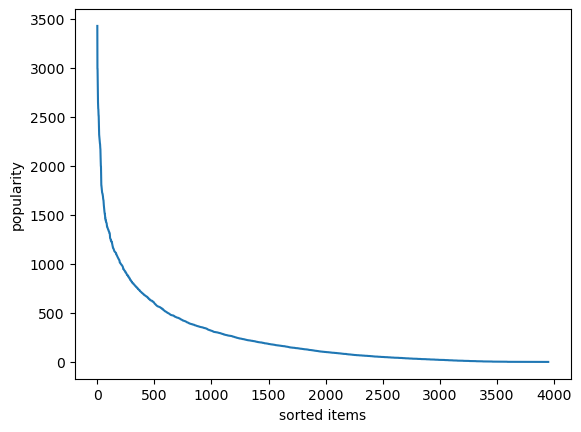

In [8]:
# Counts number of ratings for each item(Movie)
itemRateNumCurrent = ratingsNum.sum(axis=0)
itemRateNumCurrent.sort()

plt.plot(itemRateNumCurrent[::-1])
plt.xlabel('sorted items') # adds label to x axis
plt.ylabel('popularity') # adds label to y axis
plt.show()

### 1.2 kNN Model setup

To compare and implement user-based (user-user) collaborative filtering we need to create a new matrix showing the similarity between users. cosine_similarity is being used as was used in the week 11 practical.  

In [9]:
# Calculate the cosine similarity between users
from sklearn.metrics.pairwise import cosine_similarity

# Fill NaN with 0s for similarity computation
user_item_filled = user_item_matrix.fillna(0)
cosine_sim = cosine_similarity(user_item_filled)
cosine_sim = pd.DataFrame(cosine_sim)
cosine_sim

,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
1,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
2,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
3,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
4,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.186329,0.228241,0.143264,0.170583,0.293365,0.093583,0.122441,0.227400,0.239607,0.338072,...,0.131294,0.209843,0.186426,0.103431,0.267405,1.000000,0.341462,0.124174,0.219115,0.411891
6036,0.135979,0.206274,0.107744,0.127464,0.172686,0.065788,0.111673,0.144395,0.225055,0.246902,...,0.142309,0.276134,0.129985,0.118749,0.141676,0.341462,1.000000,0.049015,0.252146,0.428240
6037,0.000000,0.066118,0.120234,0.062907,0.020459,0.065711,0.000000,0.019242,0.093470,0.113789,...,0.108837,0.106897,0.040689,0.000000,0.063967,0.124174,0.049015,1.000000,0.161714,0.099300
6038,0.174604,0.066457,0.094675,0.064634,0.027689,0.167303,0.014977,0.044660,0.046434,0.296776,...,0.118776,0.250994,0.053750,0.102168,0.068399,0.219115,0.252146,0.161714,1.000000,0.228332


Cosine isn't the only method to measure the similarity between users. The other method that was Euclidian Distance based similarity.

In [10]:
# Calculate the euclididean distance between users
from sklearn.metrics.pairwise import euclidean_distances

euclidean_sim = euclidean_distances(user_item_filled)
euclidean_sim = pd.DataFrame(euclidean_sim)
euclidean_sim

,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,0.000000,51.000000,39.560081,34.409301,53.898052,41.364236,38.209946,52.611786,44.204072,81.841310,...,38.039453,51.185936,41.940434,35.832946,56.044625,101.906820,58.694122,35.580894,48.959167,72.235725
1,51.000000,0.000000,48.497423,44.754888,60.415230,52.345009,43.023250,57.332364,52.943366,85.504386,...,49.193496,58.711157,46.108568,47.465777,60.365553,102.323018,62.257530,46.010868,59.732738,73.613857
2,39.560081,48.497423,0.000000,32.326460,53.553711,42.544095,35.028560,53.207142,45.705580,82.843225,...,38.262253,48.959167,38.444766,34.568772,55.569776,102.927159,58.617404,31.859065,50.019996,71.630999
3,34.409301,44.754888,32.326460,0.000000,50.209561,38.768544,29.359837,49.193496,42.379240,84.023806,...,31.606961,46.021734,29.410882,27.604347,52.659282,101.552942,55.362442,25.690465,46.850827,69.641941
4,53.898052,60.415230,53.553711,50.209561,0.000000,56.497788,50.189640,58.745213,52.867760,91.416629,...,52.306787,62.872888,54.516053,49.849774,62.513998,99.929975,65.406422,49.909919,63.356136,73.966209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,101.906820,102.323018,102.927159,101.552942,99.929975,105.347046,102.941731,103.087342,101.108852,108.761206,...,103.179455,103.077641,101.872469,102.844543,101.892100,0.000000,98.711701,102.357218,102.742396,97.729218
6036,58.694122,62.257530,58.617404,55.362442,65.406422,61.935450,56.982453,66.520673,59.455866,88.107888,...,57.463032,59.422218,58.753723,55.398556,68.673139,98.711701,0.000000,56.258333,60.530984,67.461100
6037,35.580894,46.010868,31.859065,25.690465,49.909919,36.918830,30.133038,49.959984,41.617304,83.928541,...,31.511903,45.099889,34.713110,26.115130,52.373658,102.357218,56.258333,0.000000,44.463468,70.042844
6038,48.959167,59.732738,50.019996,46.850827,63.356136,50.517324,49.789557,62.825154,57.489129,82.468176,...,49.112117,53.357286,52.038447,45.967380,64.482556,102.742396,60.530984,44.463468,0.000000,73.232506


In [11]:
user_item_filled

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 Predict Ratings for the test user

In [12]:
# Randomly select a user (e.g., User ID 10 for this example)
user_id = 10  # Replace with random.choice(range(n_users)) if you want a truly random user
k = 10        # Number of neighbors

# Make this a function foe ease of use later
def kNN_recommender(k, user_id, user_item_matrix, similarity_matrix):

    # DataFrame to store predicted ratings for this user
    user_predictions = pd.DataFrame(index=movies['MovieID'], columns=['predicted_rating'])

    # A very small epsilon to prevent division by zero
    epsilon = 1e-9
    
    # Calculate user's average rating as a fallback
    user_ratings = user_item_matrix.iloc[user_id, :]
    user_avg_rating = user_ratings[user_ratings > 0].mean() if not user_ratings[user_ratings > 0].empty else 0

    # Predict the rating for every movie in the dataset
    for movie_id in range(user_item_matrix.shape[1]):
        # Identify users who have rated this movie
        mask_rated_users = user_item_matrix.iloc[:, movie_id] > 0
        
        # Retrieve top-k neighbors' similarity and ratings
        top_neighbours_indices = mask_rated_users.index[mask_rated_users]
        top_neighbours = similarity_matrix.loc[top_neighbours_indices - 1, user_id - 1].sort_values(ascending=False)[:k].index

        # Retrieve the ratings of the top neighbors for the specific movie
        neighbours_ratings = user_item_matrix.iloc[top_neighbours, movie_id]
        top_neighbours_sim = similarity_matrix.loc[top_neighbours_indices - 1, user_id - 1].sort_values(ascending=False)[:k].values
        
        # Compute predicted rating if neighbors exist, otherwise use average rating
        if not top_neighbours_sim.any():
            predicted_rating = user_avg_rating
        else:
            predicted_rating = sum(neighbours_ratings * top_neighbours_sim) / (sum(top_neighbours_sim) + epsilon)
        
        # Store the predicted rating in the DataFrame
        user_predictions.iloc[movie_id] = predicted_rating
    return(user_predictions)

In [13]:
#Run function for Cosine similarity
user_predictions_cosine = kNN_recommender(k, user_id, user_item_filled, cosine_sim)

# Display top predicted ratings for this user
user_predictions_cosine = user_predictions_cosine.dropna()  # Remove any empty rows
user_predictions_cosine = user_predictions_cosine.sort_values(by='predicted_rating', ascending=False)
user_predictions_cosine.head(10)  # Shows the top 10 predicted ratings for this user

,predicted_rating
MovieID,
754,5.0
3079,5.0
3436,5.0
3704,5.0
3024,5.0
938,5.0
3483,5.0
1699,5.0
3221,5.0


In [14]:
#Run function for Euclidean distance similarity
user_predictions_euclidean = kNN_recommender(k, user_id, user_item_filled, euclidean_sim)

# Display top predicted ratings for this user
user_predictions_euclidean = user_predictions_euclidean.dropna()  # Remove any empty rows
user_predictions_euclidean = user_predictions_euclidean.sort_values(by='predicted_rating', ascending=False)
user_predictions_euclidean.head(10)  # Shows the top 10 predicted ratings for this user

,predicted_rating
MovieID,
1030,5.0
1124,5.0
583,5.0
290,5.0
2626,5.0
1308,5.0
754,5.0
3079,5.0
3123,5.0


### 1.4 Evaluate model with the RMSE

In [15]:
#from sklearn.metrics import root_mean_squared_error #function will not import
from sklearn.metrics import mean_squared_error 

def rmse (y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return(rmse)

def evaluate_rmse(user_id, user_predictions, ratings):
    
    # Get actual ratings for the user
    user_actuals = ratings[ratings['UserID'] == user_id].set_index('MovieID')['Rating']

    # Join actual ratings with predictions based on MovieID
    evaluation_df = user_predictions.join(user_actuals, how='inner')
    evaluation_df.columns = ['predicted_rating', 'actual_rating']

    # Drop NaNs from predicted ratings before calculating RMSE
    evaluation_df = evaluation_df.dropna()
    
    # Calculate RMSE
    if not evaluation_df.empty:
        rmse_val = rmse(evaluation_df['actual_rating'], evaluation_df['predicted_rating'])
        print(f"RMSE for User {user_id}: {rmse_val:.2f}")
        return (rmse_val)
    else:
        print(f"No ratings available to evaluate for User {user_id}.")
        return None


For Cosine Similarity:

In [16]:
cosine_rmse = evaluate_rmse(user_id, user_predictions_cosine, ratings)
print(cosine_rmse)

# Get actual ratings for the user
user_actuals = ratings[ratings['UserID'] == user_id].set_index('MovieID')['Rating']

# Join actual ratings with predictions based on MovieID
evaluation_cosine_df = user_predictions_cosine.join(user_actuals, how='inner')
evaluation_cosine_df.columns = ['predicted_rating', 'actual_rating']
evaluation_cosine_df.head(10)

RMSE for User 10: 1.39
1.3920947348125463


,predicted_rating,actual_rating
MovieID,,
3704,5.0,2
938,5.0,4
904,4.734604,4
2378,4.621048,3
1,4.53403,5
1124,4.533703,5
916,4.501067,5
1513,4.41753,3
1276,4.405906,3


For Euclidean distance similarity:

In [17]:
euclidean_rmse = evaluate_rmse(user_id, user_predictions_euclidean, ratings)
print(euclidean_rmse)

# Get actual ratings for the user
user_actuals = ratings[ratings['UserID'] == user_id].set_index('MovieID')['Rating']

# Join actual ratings with predictions based on MovieID
evaluation_euclidean_df = user_predictions_euclidean.join(user_actuals, how='inner')
evaluation_euclidean_df.columns = ['predicted_rating', 'actual_rating']
evaluation_euclidean_df.head(10)

RMSE for User 10: 1.27
1.274855578345189


,predicted_rating,actual_rating
MovieID,,
1030,5.0,3
1124,5.0,5
3704,5.0,2
938,5.0,4
2770,4.909262,4
904,4.908391,4
597,4.902484,4
1256,4.882671,3
1204,4.879096,4


### 1.5 Compare Similarity metrics and find optimal k

In [18]:
def evaluate_similarity_metrics(k, user_subset, user_item_matrix, ratings, cosine_sim_matrix, euclidean_sim_matrix):
    # DataFrame to store RMSE results for each user and similarity metric
    rmse_results = pd.DataFrame(columns=['UserID', 'Cosine_RMSE', 'Euclidean_RMSE'])

    for user_id in user_subset:
        # Get predictions using cosine similarity
        user_predictions_cosine = kNN_recommender(k, user_id, user_item_matrix, cosine_sim)
        cosine_rmse = evaluate_rmse(user_id, user_predictions_cosine, ratings)

        # Get predictions using Euclidean distance similarity
        user_predictions_euclidean = kNN_recommender(k, user_id, user_item_matrix, euclidean_sim)
        euclidean_rmse = evaluate_rmse(user_id, user_predictions_euclidean, ratings)

        # Append RMSE results for this user
        # Create a new DataFrame for the current user's results and concatenate
        new_row = pd.DataFrame({'UserID': [user_id], 'Cosine_RMSE': [cosine_rmse], 'Euclidean_RMSE': [euclidean_rmse]})
        rmse_results = pd.concat([rmse_results, new_row], ignore_index=True)

    return rmse_results

Run this function to generate a table of RMSE values for a subset of users

In [19]:
# Randomly select 10 users from the range of user IDs
np.random.seed(72)
user_subset = random.sample(range(1, user_item_matrix.shape[0] + 1), 10)

# Calculate RMSE for the subset of users using both similarity metrics
rmse_results = evaluate_similarity_metrics(k, user_subset=user_subset, 
                                           user_item_matrix=user_item_filled, 
                                           ratings=ratings, 
                                           cosine_sim_matrix=cosine_sim, 
                                           euclidean_sim_matrix=euclidean_sim)

RMSE for User 3692: 1.43
RMSE for User 3692: 1.35
RMSE for User 612: 1.26
RMSE for User 612: 1.26
RMSE for User 3217: 1.35
RMSE for User 3217: 1.27
RMSE for User 5340: 1.33
RMSE for User 5340: 1.20
RMSE for User 677: 1.63
RMSE for User 677: 1.50
RMSE for User 5792: 1.29
RMSE for User 5792: 1.16
RMSE for User 4018: 1.22
RMSE for User 4018: 1.17
RMSE for User 4897: 1.09
RMSE for User 4897: 1.12
RMSE for User 5646: 1.40
RMSE for User 5646: 1.40
RMSE for User 2440: 1.08
RMSE for User 2440: 1.09


In [20]:
rmse_results

,UserID,Cosine_RMSE,Euclidean_RMSE
0,3692,1.434888,1.346689
1,612,1.259147,1.258165
2,3217,1.351847,1.274884
3,5340,1.331996,1.195456
4,677,1.627334,1.496472
5,5792,1.289987,1.160535
6,4018,1.219164,1.169664
7,4897,1.089262,1.121518
8,5646,1.404314,1.400662
9,2440,1.081389,1.086283


In [21]:
# Average RMSE for these users
print("Average Cosine RMSE:" + str(rmse_results['Cosine_RMSE'].mean()))
print("Average Euclidean RMSE:" + str(rmse_results['Euclidean_RMSE'].mean()))

Average Cosine RMSE:1.3089326518398032
Average Euclidean RMSE:1.2510328252977736


The Euclidean distance is shown to perform better for k = 10 

In [22]:
def evaluate_all_k(k_values, user_subset, user_item_matrix, ratings, cosine_sim_matrix, euclidean_sim_matrix):
    results_summary = pd.DataFrame(columns=['k', 'Ave_Cosine_RMSE', 'Ave_Euclidean_RMSE'])

    for k in k_values:
        rmse_results = evaluate_similarity_metrics(k, user_subset, user_item_matrix, ratings, cosine_sim_matrix, euclidean_sim_matrix)

        # Calculate average RMSE for each similarity metric
        avg_cosine_rmse = rmse_results['Cosine_RMSE'].mean()
        avg_euclidean_rmse = rmse_results['Euclidean_RMSE'].mean()
        
        # Create a DataFrame for the current k's results
        current_results = pd.DataFrame({'k': [k], 'Ave_Cosine_RMSE': [avg_cosine_rmse], 'Ave_Euclidean_RMSE': [avg_euclidean_rmse]})
        
        # Concatenate the current results with the summary DataFrame
        results_summary = pd.concat([results_summary, current_results], ignore_index=True)

    return results_summary

In [23]:
# Define your k values and user subset
k_values = [5, 10, 15, 20, 25]

# Randomly select 50 users from the range of user IDs
np.random.seed(72)
user_subset = random.sample(range(1, user_item_matrix.shape[0] + 1), 10)

In [24]:
# Now you can call the evaluate_all_k function
start_time = time.time()
results_df = evaluate_all_k(k_values, user_subset, user_item_matrix, ratings, cosine_sim, euclidean_sim)
# Print time taken to run function.
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

RMSE for User 3746: 1.57
RMSE for User 3746: 1.44
RMSE for User 5448: 1.38
RMSE for User 5448: 1.34
RMSE for User 2509: 1.18
RMSE for User 2509: 1.26
RMSE for User 2084: 1.34
RMSE for User 2084: 1.11
RMSE for User 3259: 1.43
RMSE for User 3259: 1.20
RMSE for User 4688: 1.55
RMSE for User 4688: 1.38
RMSE for User 2378: 1.48
RMSE for User 2378: 1.56
RMSE for User 1336: 1.37
RMSE for User 1336: 1.05
RMSE for User 96: 1.21
RMSE for User 96: 1.11
RMSE for User 4821: 1.42
RMSE for User 4821: 1.38
RMSE for User 3746: 1.55
RMSE for User 3746: 1.43
RMSE for User 5448: 1.34
RMSE for User 5448: 1.34
RMSE for User 2509: 1.18
RMSE for User 2509: 1.27
RMSE for User 2084: 1.30
RMSE for User 2084: 1.10
RMSE for User 3259: 1.40
RMSE for User 3259: 1.23
RMSE for User 4688: 1.52
RMSE for User 4688: 1.38
RMSE for User 2378: 1.45
RMSE for User 2378: 1.54
RMSE for User 1336: 1.32
RMSE for User 1336: 1.08
RMSE for User 96: 1.17
RMSE for User 96: 1.11
RMSE for User 4821: 1.39
RMSE for User 4821: 1.36
RMSE for

In [25]:
results_df

,k,Ave_Cosine_RMSE,Ave_Euclidean_RMSE
0,5,1.393490,1.283572
1,10,1.361533,1.284629
2,15,1.347768,1.286295
3,20,1.340639,1.290575
4,25,1.332375,1.286488


The best performing result was the Euclidean similarity method with k = 25

In [26]:
#results_df.to_csv('results_n10.csv', index=False)

### 1.6 Visualisations for slides

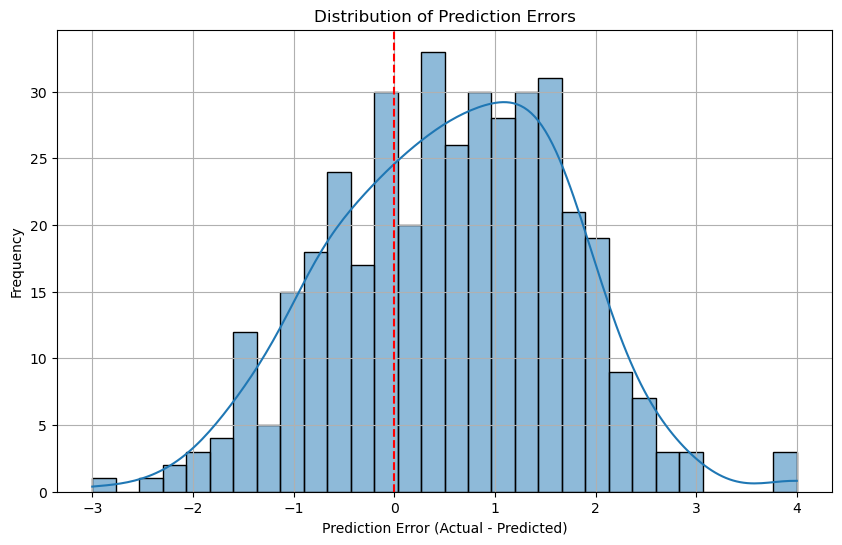

In [28]:
# Distribution of Prediction Errors
evaluation_euclidean_df['Error'] = evaluation_euclidean_df['actual_rating'] - evaluation_euclidean_df['predicted_rating']

plt.figure(figsize=(10, 6))
sns.histplot(evaluation_euclidean_df['Error'], bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line at error = 0
plt.grid()
plt.show()

In [29]:
evaluation_euclidean_df

,predicted_rating,actual_rating,Error
MovieID,,,
1030,5.0,3,-2.0
1124,5.0,5,0.0
3704,5.0,2,-3.0
938,5.0,4,-1.0
2770,4.909262,4,-0.909262
...,...,...,...
1307,1.0,5,4.0
3155,1.0,5,4.0
1927,1.0,3,2.0


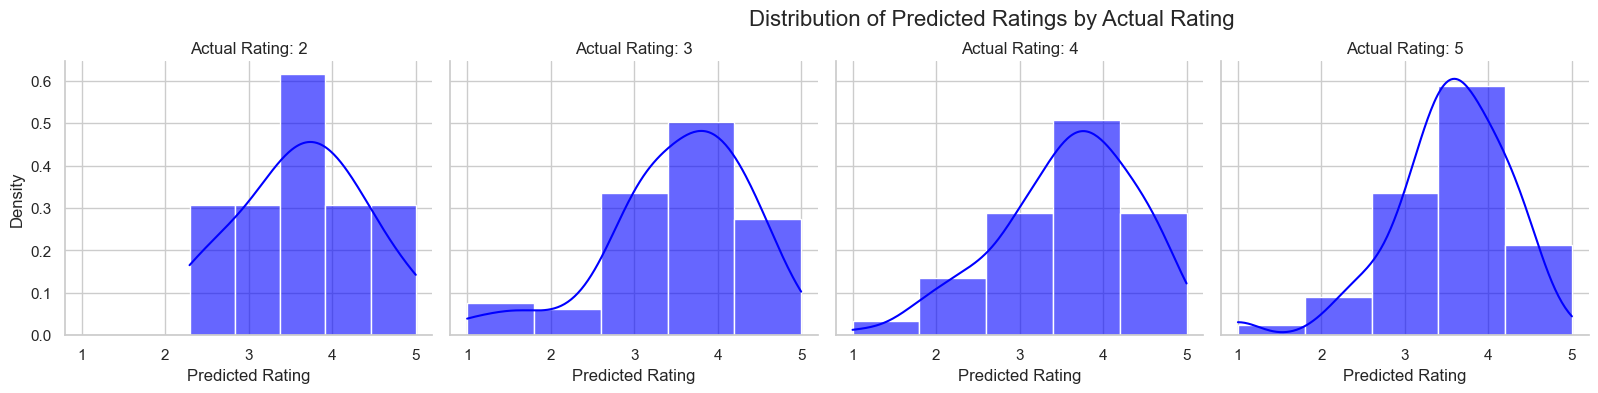

In [31]:
# Distribution of Predicted Ratings by Actual Rating
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a FacetGrid to plot the distribution of Predicted Ratings for each Actual Rating
g = sns.FacetGrid(evaluation_euclidean_df, col="actual_rating", col_wrap=5, height=4, aspect=1)

# Map the histogram or KDE plot to the grid
g.map(sns.histplot, 'predicted_rating', kde=True, bins=5, color='blue', stat='density', alpha=0.6)

# Adjust the titles and labels
g.set_titles("Actual Rating: {col_name}")
g.set_axis_labels("Predicted Rating", "Density")

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Predicted Ratings by Actual Rating', fontsize=16)
plt.show()

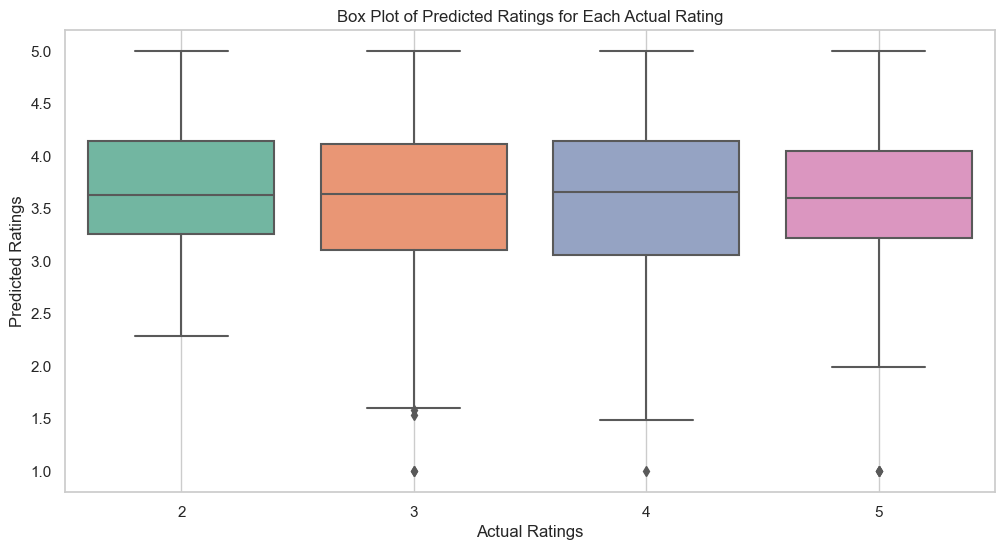

In [32]:
# Box Plot of Predicted Ratings for Each Actual Rating
plt.figure(figsize=(12, 6))
sns.boxplot(data=evaluation_euclidean_df, x='actual_rating', y='predicted_rating', palette="Set2")
plt.title('Box Plot of Predicted Ratings for Each Actual Rating')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid()
plt.show()

# Task 2: Matrix Factorization-based Recommendation

In this task, you need to explore, implement, and evaluate a recommender system that uses a matrix factorization technique of your choice. Examples of matrix factorization techniques include, but not limited to, Singular Value Decomposition (SVD), Non-negative Matrix Factorization (NMF), Alternating Least Squares (ALS), and their variants.

Randomly choose 5 items (i.e., movies; as test set) and predict all users' ratings on these movies. Note that in the given dataset, it is possible that some users didn't rate a chosen movie.

### 2.1 Select Matrix Factorization Technique and prepare data

Use a library called scikit.surprise which is a library designed for reccomender systems. It also features a number of functions to implement matrix factorisation. 

In [33]:
#!pip install scikit-surprise

In [34]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [35]:
# Prepare data for scikit-surprise
# The surprise kit doesn't use data frames so it has to be reread from file. 
reader = Reader(line_format='user item rating timestamp', sep='::')
data = Dataset.load_from_file('ml-1m/ratings.dat', reader=reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize and train the SVD model
svd = SVD()
svd.fit(trainset)

# Predict ratings for the testset
predictions_MF = svd.test(testset)
rmse_MF = accuracy.rmse(predictions_MF)

RMSE: 0.8785


In [36]:
predictions_MF = pd.DataFrame(predictions_MF)
predictions_MF

,uid,iid,r_ui,est,details
0,5841,2791,5.0,4.457682,{'was_impossible': False}
1,5334,127,1.0,2.125948,{'was_impossible': False}
2,3925,3203,3.0,4.063689,{'was_impossible': False}
3,5558,1573,5.0,2.657225,{'was_impossible': False}
4,1140,2366,5.0,4.359074,{'was_impossible': False}
...,...,...,...,...,...
250048,1317,3481,4.0,3.922975,{'was_impossible': False}
250049,2383,1721,2.0,3.013121,{'was_impossible': False}
250050,476,1690,5.0,3.356800,{'was_impossible': False}
250051,5102,2710,4.0,3.848959,{'was_impossible': False}


The surpise kit gives an output with the following variables: uid, iid, r_ui, est, details.

1. <b>uid:</b> This column represents the user ID of the user for whom the prediction is made. 
2. <b>iid:</b> This stands for item ID (in this case, the Movie ID).
3. <b>r_ui:</b> This column contains the actual rating given by the user for that movie in the test set. 
4. <b>est:</b> This is the estimated rating predicted by your SVD model for the specified user and movie combination.
5. <b>details:</b> This indicates if the calculation was possible or not. For the most part {'was_impossible': False} means the calculation was made

In [37]:
#Remove and Rename columns
predictions_MF.drop("details", axis = 1, inplace = True)
predictions_MF.columns = ["UserID", "MovieID", "Actual Rating", "Predicted Rating"]
predictions_MF

,UserID,MovieID,Actual Rating,Predicted Rating
0,5841,2791,5.0,4.457682
1,5334,127,1.0,2.125948
2,3925,3203,3.0,4.063689
3,5558,1573,5.0,2.657225
4,1140,2366,5.0,4.359074
...,...,...,...,...
250048,1317,3481,4.0,3.922975
250049,2383,1721,2.0,3.013121
250050,476,1690,5.0,3.356800
250051,5102,2710,4.0,3.848959


### 2.2 Chose 5 movies and predict all user ratings

In [38]:
# Randomly select 5 movie IDs from the range of movie IDs
np.random.seed(35)
num_movies = movies["MovieID"].max()
movie_subset = np.random.choice(range(1, num_movies + 1), size=5, replace=False)

print("Randomly selected movie IDs:", movie_subset)

Randomly selected movie IDs: [1117 2212 1175   82  121]


In [39]:
# Predict ratings for all users for the selected movies
user_ids = np.unique([uid for uid in trainset.all_users()])  # Get all user IDs from the training set
predictions = []

for movie_id in movie_subset:
    for user_id in user_ids:
        pred = svd.predict(user_id, movie_id)
        predictions.append(pred)

# Convert predictions to a DataFrame for better readability
predictions_df = pd.DataFrame(predictions, columns=['UserID', 'MovieID', 'r_ui', 'Predicted Rating', 'details'])
predictions_df.drop(["r_ui", "details"], axis= 1, inplace=True)
predictions_df

,UserID,MovieID,Predicted Rating
0,0,1117,3.582047
1,1,1117,3.582047
2,2,1117,3.582047
3,3,1117,3.582047
4,4,1117,3.582047
...,...,...,...
30195,6035,121,3.582047
30196,6036,121,3.582047
30197,6037,121,3.582047
30198,6038,121,3.582047


### 2.3 Evaluate with RMSE

Unfortunately since we are choosing random movies it's almost it's unlikely many users have rated these films. Therefore making it very hard to evaluate as we don't have the actual ratings to compare them too.

What we can do like in the first part is to create a test set for users who have rated these films then use the model to make a predicted rating for us to compare and evaluate.

In [40]:
# Find users who rated the selected movies
users_who_rated = ratings[ratings['MovieID'].isin(movie_subset)]
unique_users = users_who_rated['UserID'].unique()
unique_users.shape

(572,)

In [41]:
users_who_rated

,UserID,MovieID,Rating
256,5,1175,5
4263,33,1175,2
7381,53,1175,5
8259,58,1175,5
8696,59,1175,4
...,...,...,...
990504,5980,2212,3
990765,5981,2212,4
991211,5986,82,5
991272,5987,1175,5


Create a test set using these users

In [42]:
test_set = users_who_rated[['UserID', 'MovieID', 'Rating']].reset_index(drop=True)
test_set

,UserID,MovieID,Rating
0,5,1175,5
1,33,1175,2
2,53,1175,5
3,58,1175,5
4,59,1175,4
...,...,...,...
629,5980,2212,3
630,5981,2212,4
631,5986,82,5
632,5987,1175,5


Create training set by excluding test set from the data

In [43]:
# Create a set of UserID and MovieID tuples from the test set for filtering
test_set_ids = set(zip(test_set['UserID'], test_set['MovieID']))

# Prepare the training set by excluding these ratings
train_set = ratings[~ratings.set_index(['UserID', 'MovieID']).index.isin(test_set_ids)]
train_set

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [44]:
# Prepare the Surprise dataset from the training set
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are from 1 to 5
train_data = Dataset.load_from_df(train_set[['UserID', 'MovieID', 'Rating']], reader)

# Initialize and train the SVD model
svd = SVD()
trainset = train_data.build_full_trainset()  # Using full training set since we already filtered
svd.fit(trainset)

# Use the trained model to predict ratings for the test set
predictions = []
for _, row in test_set.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    actual_rating = row['Rating']
    pred = svd.predict(user_id, movie_id)
    predictions.append((user_id, movie_id, actual_rating, pred.est))

# Convert predictions to a DataFrame for better readability
predictions_df = pd.DataFrame(predictions, columns=['UserID', 'MovieID', 'Actual Rating', 'Predicted Rating'])
predictions_df

,UserID,MovieID,Actual Rating,Predicted Rating
0,5,1175,5,2.794195
1,33,1175,2,3.265778
2,53,1175,5,4.221468
3,58,1175,5,3.834674
4,59,1175,4,2.959965
...,...,...,...,...
629,5980,2212,3,3.183038
630,5981,2212,4,3.142587
631,5986,82,5,3.991637
632,5987,1175,5,3.171818


In [45]:
# Evaluate the model using RMSE
predictions_for_rmse = [(row['UserID'], row['MovieID'], row['Actual Rating'], row['Predicted Rating'], None) for _, row in predictions_df.iterrows()]
filtered_rmse = accuracy.rmse(predictions_for_rmse)

print(f'RMSE for the selected movies: {filtered_rmse}')

RMSE: 1.0435
RMSE for the selected movies: 1.043464695783782


### 2.4 Improve performance with a model improvement

The surprise package also has another function which allows the model to use more features of either the user or the movies. In our case the movies has the genres for each film, users have demographic information and the ratings also show when it was rated all important information which can impact the ratings of a movie. 

In [46]:
from surprise import Dataset, Reader, SVDpp, accuracy

In [47]:
# Include user information within the ratings data frame to use in the model
ratings_with_user_info = pd.merge(ratings, users, on='UserID', how='left')
# Encode categorical user features as the model only supports numerical values
ratings_with_user_info['Gender'] = ratings_with_user_info['Gender'].map({'M': 0, 'F': 1})
ratings_with_user_info

,UserID,MovieID,Rating,Gender,Age,Occupation,Zip-code
0,1,1193,5,1,1,10,48067
1,1,661,3,1,1,10,48067
2,1,914,3,1,1,10,48067
3,1,3408,4,1,1,10,48067
4,1,2355,5,1,1,10,48067
...,...,...,...,...,...,...,...
1000204,6040,1091,1,0,25,6,11106
1000205,6040,1094,5,0,25,6,11106
1000206,6040,562,5,0,25,6,11106
1000207,6040,1096,4,0,25,6,11106


In [48]:
# Use the same subset of movies and users as before for comparison between models
users_who_rated = ratings_with_user_info[ratings_with_user_info['MovieID'].isin(movie_subset)]
unique_users = users_who_rated['UserID'].unique()
print(f'Random choice of 5 movies: {movie_subset}')
print(f'Number of unique users who rated the selected movies: {unique_users.shape[0]}')

Random choice of 5 movies: [1117 2212 1175   82  121]
Number of unique users who rated the selected movies: 572


To implement the other data into the model we have to code each variable as a unique item.

In [49]:
# Generate Implicit Feedback Data for All Users
all_user_ids = ratings_with_user_info['UserID'].unique()
implicit_data_all = []

for user_id in all_user_ids:
    # Gender as an implicit item
    gender_item_id = f'gender_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Gender"].values[0]}'
    implicit_data_all.append([user_id, gender_item_id, 1])  # Implicit rating of 1
    
    # Age as an implicit item
    age_group_item_id = f'age_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Age"].values[0]}'
    implicit_data_all.append([user_id, age_group_item_id, 1])  # Implicit rating of 1
    
    # Occupation as an implicit item
    occupation_item_id = f'occupation_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Occupation"].values[0]}'
    implicit_data_all.append([user_id, occupation_item_id, 1])  # Implicit rating of 1
    
    # Zip-code as an implicit item
    zip_code_item_id = f'zip_code_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Zip-code"].values[0]}'
    implicit_data_all.append([user_id, zip_code_item_id, 1])  # Implicit rating of 1 
    
# Convert to DataFrame
implicit_df_all = pd.DataFrame(implicit_data_all, columns=['UserID', 'MovieID', 'Rating'])
implicit_df_all

,UserID,MovieID,Rating
0,1,gender_1,1
1,1,age_1,1
2,1,occupation_10,1
3,1,zip_code_48067,1
4,2,gender_0,1
...,...,...,...
24155,6039,zip_code_01060,1
24156,6040,gender_0,1
24157,6040,age_25,1
24158,6040,occupation_6,1


In [50]:
# Combine Implicit Data with the Original Ratings for Training
combined_data = pd.concat([ratings_with_user_info[['UserID', 'MovieID', 'Rating']], implicit_df_all])
combined_data

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
24155,6039,zip_code_01060,1
24156,6040,gender_0,1
24157,6040,age_25,1
24158,6040,occupation_6,1


In [51]:
# Extract explicit ratings that match the movies in movie_subset
test_set_explicit = ratings_with_user_info[ratings_with_user_info['MovieID'].isin(movie_subset)][['UserID', 'MovieID', 'Rating']].reset_index(drop=True)

# Create a set of UserIDs for the test set
test_user_ids = set(test_set_explicit['UserID']) 

# Find all data in combined_data that matches the UserIDs in the test set
test_set = combined_data[combined_data['UserID'].isin(test_user_ids)].reset_index(drop=True)
test_set

,UserID,MovieID,Rating
0,5,2987,4
1,5,2333,4
2,5,1175,5
3,5,39,3
4,5,288,2
...,...,...,...
209198,5987,zip_code_10003,1
209199,6020,gender_0,1
209200,6020,age_50,1
209201,6020,occupation_16,1


In [52]:
# Now create the train set by excluding the test users
train_set = combined_data[~combined_data['UserID'].isin(test_user_ids)].reset_index(drop=True)
train_set

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
815161,6039,zip_code_01060,1
815162,6040,gender_0,1
815163,6040,age_25,1
815164,6040,occupation_6,1


In [53]:
# Check for overlapping rows between train_set and test_set
overlap = pd.merge(train_set, test_set, on=['UserID', 'MovieID'], how='inner')
print(f"Number of overlapping rows: {overlap.shape[0]}")

# Check if total rows from train_set and test_set add up to combined_data
print(f"Total rows expected: {train_set.shape[0] + test_set.shape[0]}")
print(f"Total rows in combined_data: {combined_data.shape[0]}")


Number of overlapping rows: 0
Total rows expected: 1024369
Total rows in combined_data: 1024369


In [54]:
# Prepare the Dataset for Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_set[['UserID', 'MovieID', 'Rating']], reader)
train_set_surprise = train_data.build_full_trainset()

In [55]:
# Initialize and Train SVD++ Model
start_time = time.time()
svdpp = SVDpp(cache_ratings = True)
svdpp.fit(train_set_surprise)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 263.72 seconds


In [56]:
# Filter the test_set to include only the relevant MovieIDs
all_movie_ids = ratings['MovieID'].unique()
test_set_filtered = test_set[test_set['MovieID'].isin(all_movie_ids)]    

# Predict Ratings for the Test Set with a Progress Bar
predictions = []
for _, row in tqdm(test_set_filtered.iterrows(), total=test_set_filtered.shape[0], desc="Predicting ratings"):
    user_id = row['UserID']
    movie_id = row['MovieID']
    actual_rating = row['Rating']
    pred = svdpp.predict(user_id, movie_id)
    predictions.append((user_id, movie_id, actual_rating, pred.est))

# Convert predictions to DataFrame for Evaluation
predictions_df = pd.DataFrame(predictions, columns=['UserID', 'MovieID', 'Actual Rating', 'Predicted Rating'])
predictions_df

Predicting ratings: 100%|██████████| 206915/206915 [00:14<00:00, 14660.04it/s]


,UserID,MovieID,Actual Rating,Predicted Rating
0,5,2987,4,3.679236
1,5,2333,4,3.724532
2,5,1175,5,3.523141
3,5,39,3,3.782971
4,5,288,2,3.099876
...,...,...,...,...
206910,6020,1785,4,3.414099
206911,6020,1036,3,4.215882
206912,6020,1069,5,4.063332
206913,6020,2019,5,4.535755


In [57]:
# Evaluate the model using RMSE
predictions_for_rmse = [(row['UserID'], row['MovieID'], row['Actual Rating'], row['Predicted Rating'], None) for _, row in predictions_df.iterrows()]
filtered_rmse = accuracy.rmse(predictions_for_rmse)

print(f'RMSE for the selected movies using SVD++: {filtered_rmse}')

RMSE: 1.0171
RMSE for the selected movies using SVD++: 1.0170824527131355


In [58]:
def run_svdpp_with_user_features(ratings, users, movie_subset):    
    start_time = time.time()
    # Include user information within the ratings data frame to use in the model
    ratings_with_user_info = pd.merge(ratings, users, on='UserID', how='left')
    # Encode categorical user features as the model only supports numerical values
    ratings_with_user_info['Gender'] = ratings_with_user_info['Gender'].map({'M': 0, 'F': 1})

    # Use the same subset of movies and users as before for comparison between models
    users_who_rated = ratings_with_user_info[ratings_with_user_info['MovieID'].isin(movie_subset)]
    unique_users = users_who_rated['UserID'].unique()

    # Generate Implicit Feedback Data for All Users
    all_user_ids = ratings_with_user_info['UserID'].unique()
    implicit_data_all = []

    for user_id in all_user_ids:
        # Gender as an implicit item
        gender_item_id = f'gender_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Gender"].values[0]}'
        implicit_data_all.append([user_id, gender_item_id, 1])  # Implicit rating of 1
        # Age as an implicit item
        age_group_item_id = f'age_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Age"].values[0]}'
        implicit_data_all.append([user_id, age_group_item_id, 1])  # Implicit rating of 1
        # Occupation as an implicit item
        occupation_item_id = f'occupation_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Occupation"].values[0]}'
        implicit_data_all.append([user_id, occupation_item_id, 1])  # Implicit rating of 1
        # Zip-code as an implicit item
        zip_code_item_id = f'zip_code_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Zip-code"].values[0]}'
        implicit_data_all.append([user_id, zip_code_item_id, 1])  # Implicit rating of 1 

    implicit_df_all = pd.DataFrame(implicit_data_all, columns=['UserID', 'MovieID', 'Rating'])

    # Combine Implicit Data with the Original Ratings for Training
    combined_data = pd.concat([ratings_with_user_info[['UserID', 'MovieID', 'Rating']], implicit_df_all])

    # Extract explicit ratings that match the movies in movie_subset
    test_set_explicit = ratings_with_user_info[ratings_with_user_info['MovieID'].isin(movie_subset)][['UserID', 'MovieID', 'Rating']].reset_index(drop=True)

    # Create a set of UserIDs for the test set
    test_user_ids = set(test_set_explicit['UserID']) 
    test_set = combined_data[combined_data['UserID'].isin(test_user_ids)].reset_index(drop=True)

    # Now create the train set by excluding the test users
    train_set = combined_data[~combined_data['UserID'].isin(test_user_ids)].reset_index(drop=True)

    # Prepare the Dataset for Surprise
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(train_set[['UserID', 'MovieID', 'Rating']], reader)
    train_set_surprise = train_data.build_full_trainset()

    # Initialize and Train SVD++ Model
    svdpp = SVDpp(cache_ratings = True)
    svdpp.fit(train_set_surprise)

    # Filter the test_set to include only the relevant MovieIDs
    all_movie_ids = ratings['MovieID'].unique()
    test_set_filtered = test_set[test_set['MovieID'].isin(all_movie_ids)]    
    
    # Predict Ratings for the Test Set with a Progress Bar
    predictions = []
    for _, row in tqdm(test_set_filtered.iterrows(), total=test_set_filtered.shape[0], desc="Predicting ratings"):
        user_id = row['UserID']
        movie_id = row['MovieID']
        actual_rating = row['Rating']
        pred = svdpp.predict(user_id, movie_id)
        predictions.append((user_id, movie_id, actual_rating, pred.est))

    # Convert predictions to DataFrame for Evaluation
    predictions_df = pd.DataFrame(predictions, columns=['UserID', 'MovieID', 'Actual Rating', 'Predicted Rating'])

    # Evaluate the model using RMSE
    predictions_for_rmse = [(row['UserID'], row['MovieID'], row['Actual Rating'], row['Predicted Rating'], None) for _, row in predictions_df.iterrows()]
    filtered_rmse = accuracy.rmse(predictions_for_rmse)

    print(f'RMSE for the selected movies using SVD++: {filtered_rmse}')
    
    #Print time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    if predictions_df.empty:
        raise ValueError("No predictions were made. Please check the input data.")

    return predictions_df

In [59]:
# Test Run function
#predictions_df = run_svdpp_with_user_features(ratings, users, movie_subset)

In [60]:
#predictions_df

### 2. 5 Visualisations for slides

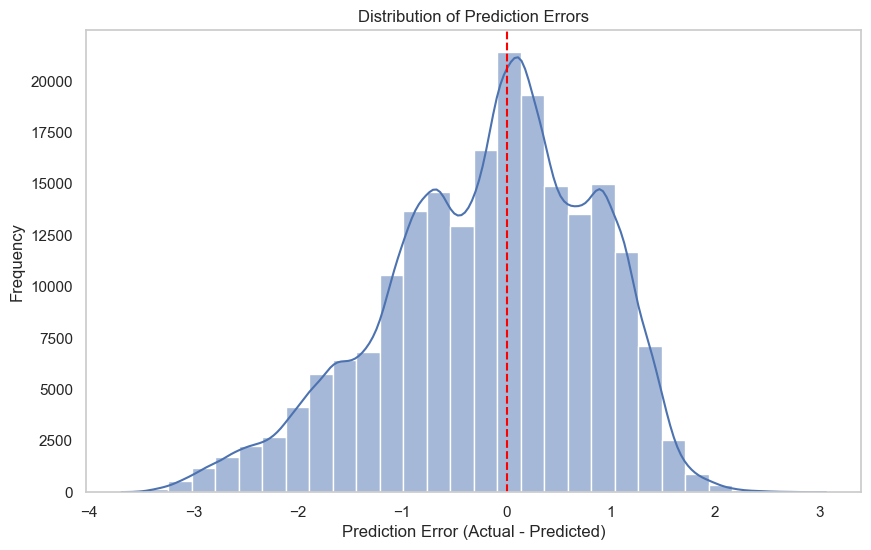

In [61]:
# Calculate the prediction errors
predictions_df['Error'] = predictions_df['Actual Rating'] - predictions_df['Predicted Rating']

plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['Error'], bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line at error = 0
plt.grid()
plt.show()

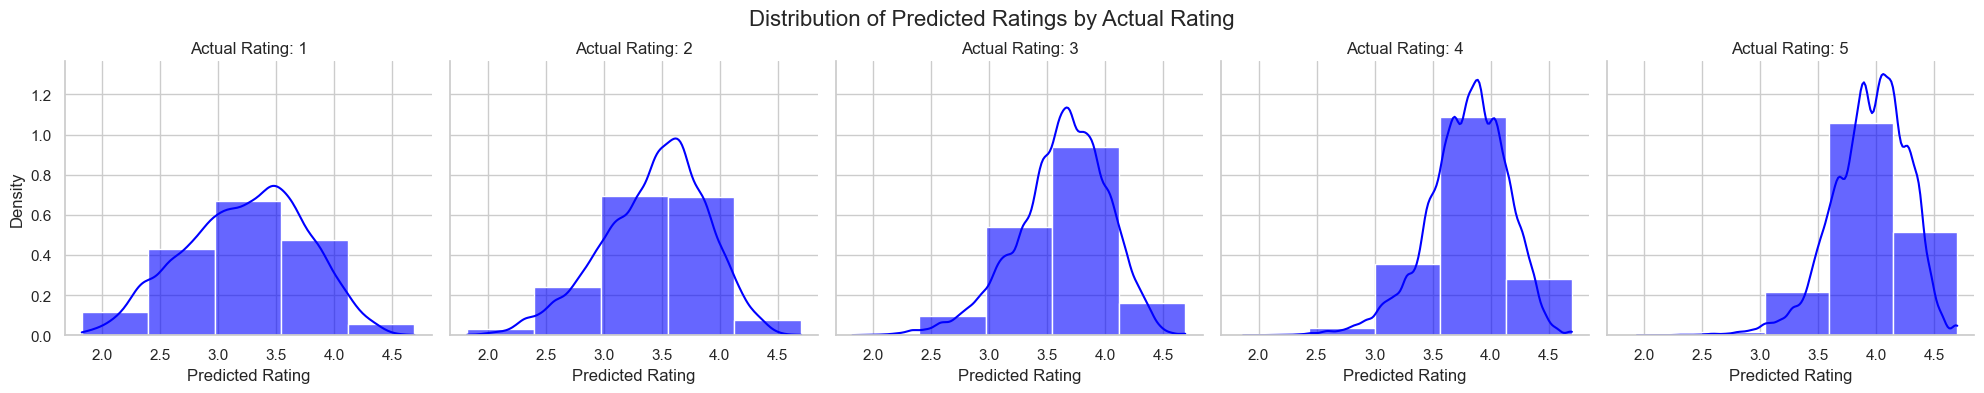

In [62]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a FacetGrid to plot the distribution of Predicted Ratings for each Actual Rating
g = sns.FacetGrid(predictions_df, col="Actual Rating", col_wrap=5, height=4, aspect=1)

# Map the histogram or KDE plot to the grid
g.map(sns.histplot, 'Predicted Rating', kde=True, bins=5, color='blue', stat='density', alpha=0.6)

# Adjust the titles and labels
g.set_titles("Actual Rating: {col_name}")
g.set_axis_labels("Predicted Rating", "Density")

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Predicted Ratings by Actual Rating', fontsize=16)
plt.show()

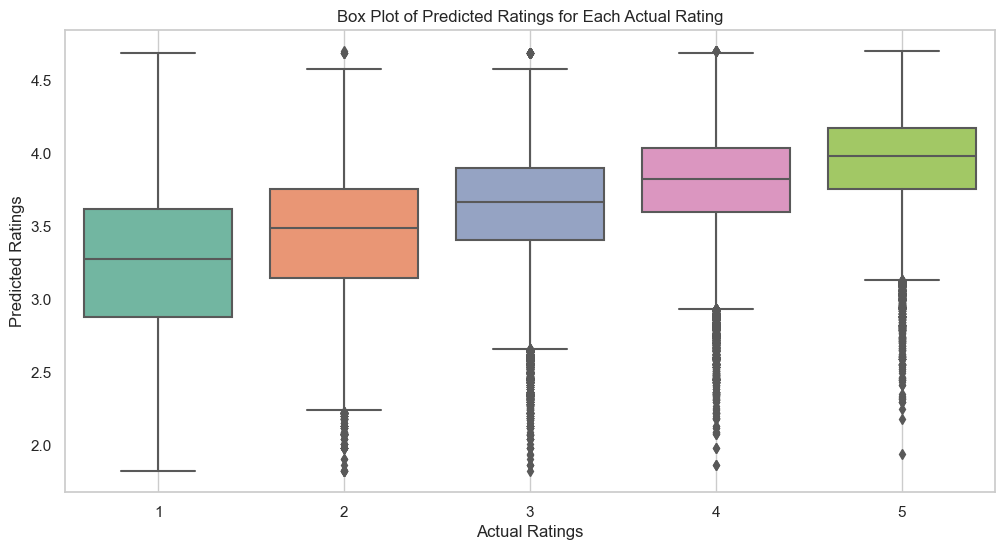

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=predictions_df, x='Actual Rating', y='Predicted Rating', palette="Set2")
plt.title('Box Plot of Predicted Ratings for Each Actual Rating')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid()
plt.show()

# Task 3: Ranking-based Evaluation and Comparison

### 3.1 Randomly Select 10 users

In [64]:
# Set random seed
np.random.seed(23)

# Count ratings per user
user_rating_counts = ratings['UserID'].value_counts()

# Filter users who have rated more than 100 movies
eligible_users = user_rating_counts[user_rating_counts > 100].index
print("Number of eligible users:", eligible_users.shape[0])

# Randomly select 10 users from this group
random_users = eligible_users.to_series().sample(n=10).tolist()

# Display the selected user IDs
print("Randomly selected user IDs:", random_users)

Number of eligible users: 2909
Randomly selected user IDs: [2611, 377, 493, 2002, 5851, 3445, 570, 3560, 4009, 2701]


### 3.2 Generate Recomendations using kNN and IMFR

## kNN

Create function to use the kNN reccomender from eariler to find the top 20 films and also make a df showing the users predicted and actual ratings.

In [65]:
def recommend_and_evaluate_knn(k, user_ids, user_item_matrix, similarity_matrix, ratings, top_n=20):
    all_recommendations = {}
    evaluation_results = {}

    for user_id in tqdm(user_ids, desc="Processing users", unit="user"):
        # Get predictions
        user_predictions = kNN_recommender(k, user_id, user_item_matrix, similarity_matrix)

        # Drop NaN values and sort predictions
        user_predictions = user_predictions.dropna()
        user_predictions = user_predictions.sort_values(by='predicted_rating', ascending=False)

        # Get top N recommendations
        top_recommendations = user_predictions.head(top_n).index.tolist()
        all_recommendations[user_id] = top_recommendations

        # Get actual ratings for the user
        user_actuals = ratings[ratings['UserID'] == user_id].set_index('MovieID')['Rating']

        # Join actual ratings with predictions based on MovieID
        evaluation_df = user_predictions.join(user_actuals, how='inner')
        evaluation_df.columns = ['predicted_rating', 'actual_rating']
        evaluation_results[user_id] = evaluation_df

    return all_recommendations, evaluation_results

In [66]:
# Example parameters
k = 25  # The optimal value from Task 1
top_n = 20
user_ids = random_users  # The list of 10 randomly selected users

# Call the function to get recommendations and evaluations
start_time = time.time()
recommendations_knn, evaluation_knn = recommend_and_evaluate_knn(k, user_ids, user_item_filled, euclidean_sim, ratings, top_n)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Processing users: 100%|██████████| 10/10 [01:07<00:00,  6.79s/user]

Elapsed time: 67.88 seconds


In [67]:
# Convert recommendations to df
recommendations_knn_df = pd.DataFrame.from_dict(recommendations_knn, orient='index', columns=[f'Recommendation {i+1}' for i in range(top_n)])
recommendations_knn_df.index.name = 'UserID'
recommendations_knn_df

,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10,Recommendation 11,Recommendation 12,Recommendation 13,Recommendation 14,Recommendation 15,Recommendation 16,Recommendation 17,Recommendation 18,Recommendation 19,Recommendation 20
UserID,,,,,,,,,,,,,,,,,,,,
2611,754,3079,3483,3436,3704,3123,3221,3024,1699,938,1124,1833,854,858,1132,3090,1308,50,597,1204
377,754,3079,3704,3436,3483,3123,1699,3024,3221,938,1124,854,50,858,1132,3090,863,1130,904,1308
493,754,3079,3704,3436,3483,3123,3024,938,1699,3221,1124,854,858,1132,3090,50,863,920,904,1160
2002,754,3079,3436,3704,3483,3123,3024,1699,938,3221,904,854,1124,1120,50,858,863,3090,1133,1030
5851,754,3079,3704,3483,3123,1699,938,3024,3221,1124,854,597,858,863,1132,3090,812,1308,583,1145
3445,754,3079,3704,3436,3483,3123,3024,938,1699,3221,1124,854,50,1145,863,858,1132,3090,812,1308
570,754,3079,3704,3436,3483,3123,3024,1699,938,3221,1124,1308,858,1132,854,1030,597,1145,863,1075
3560,754,3079,3704,3436,3483,3123,3024,1699,938,3221,1124,858,854,3090,812,1308,583,597,50,863
4009,754,3079,3704,3436,3483,1699,3024,938,3221,3123,1124,50,858,854,3090,863,1132,872,1204,1308


In [68]:
# Display recommendations for each user
recommendations_knn_df_titles = pd.DataFrame.from_dict(recommendations_knn, orient='index', columns=[f'Recommendation {i+1}' for i in range(top_n)])
recommendations_knn_df_titles.index.name = 'UserID'
# Replace MovieID with Movie Titles
for i in range(1, top_n +1):
    recommendations_knn_df_titles[f'Recommendation {i}'] = recommendations_knn_df_titles[f'Recommendation {i}'].map(movies.set_index('MovieID')['Title'])

# Sort by UserID index
recommendations_knn_df_titles = recommendations_knn_df_titles.sort_index()  
recommendations_knn_df_titles

,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10,Recommendation 11,Recommendation 12,Recommendation 13,Recommendation 14,Recommendation 15,Recommendation 16,Recommendation 17,Recommendation 18,Recommendation 19,Recommendation 20
UserID,,,,,,,,,,,,,,,,,,,,
377,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Mad Max Beyond Thunderdome (1985),Dying Young (1991),"Road to El Dorado, The (2000)",Spring Fever USA (a.k.a. Lauderdale) (1989),"Butcher Boy, The (1998)",Piranha (1978),"Draughtsman's Contract, The (1982)",Gigi (1958),On Golden Pond (1981),"Ballad of Narayama, The (Narayama Bushiko) (1958)","Usual Suspects, The (1995)","Godfather, The (1972)",Manon of the Spring (Manon des sources) (1986),Matewan (1987),Celestial Clockwork (1994),"Howling, The (1980)",Rear Window (1954),I Shot a Man in Vegas (1995)
493,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Mad Max Beyond Thunderdome (1985),Dying Young (1991),"Road to El Dorado, The (2000)",Spring Fever USA (a.k.a. Lauderdale) (1989),Piranha (1978),Gigi (1958),"Butcher Boy, The (1998)","Draughtsman's Contract, The (1982)",On Golden Pond (1981),"Ballad of Narayama, The (Narayama Bushiko) (1958)","Godfather, The (1972)",Manon of the Spring (Manon des sources) (1986),Matewan (1987),"Usual Suspects, The (1995)",Celestial Clockwork (1994),Gone with the Wind (1939),Rear Window (1954),Six of a Kind (1934)
570,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Mad Max Beyond Thunderdome (1985),Dying Young (1991),"Road to El Dorado, The (2000)",Spring Fever USA (a.k.a. Lauderdale) (1989),Piranha (1978),"Butcher Boy, The (1998)",Gigi (1958),"Draughtsman's Contract, The (1982)",On Golden Pond (1981),I Shot a Man in Vegas (1995),"Godfather, The (1972)",Manon of the Spring (Manon des sources) (1986),"Ballad of Narayama, The (Narayama Bushiko) (1958)",Pete's Dragon (1977),Pretty Woman (1990),Snowriders (1996),Celestial Clockwork (1994),"Sexual Life of the Belgians, The (1994)"
2002,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Dying Young (1991),Mad Max Beyond Thunderdome (1985),"Road to El Dorado, The (2000)",Spring Fever USA (a.k.a. Lauderdale) (1989),Piranha (1978),"Butcher Boy, The (1998)",Gigi (1958),"Draughtsman's Contract, The (1982)",Rear Window (1954),"Ballad of Narayama, The (Narayama Bushiko) (1958)",On Golden Pond (1981),"People vs. Larry Flynt, The (1996)","Usual Suspects, The (1995)","Godfather, The (1972)",Celestial Clockwork (1994),Matewan (1987),Talking About Sex (1994),Pete's Dragon (1977)
2611,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),"Road to El Dorado, The (2000)",Dying Young (1991),Mad Max Beyond Thunderdome (1985),Spring Fever USA (a.k.a. Lauderdale) (1989),"Draughtsman's Contract, The (1982)",Piranha (1978),"Butcher Boy, The (1998)",Gigi (1958),On Golden Pond (1981),Mercury Rising (1998),"Ballad of Narayama, The (Narayama Bushiko) (1958)","Godfather, The (1972)",Manon of the Spring (Manon des sources) (1986),Matewan (1987),I Shot a Man in Vegas (1995),"Usual Suspects, The (1995)",Pretty Woman (1990),Lawrence of Arabia (1962)
2701,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Mad Max Beyond Thunderdome (1985),Dying Young (1991),"Road to El Dorado, The (2000)",Spring Fever USA (a.k.a. Lauderdale) (1989),Piranha (1978),Gigi (1958),"Butcher Boy, The (1998)","Draughtsman's Contract, The (1982)",On Golden Pond (1981),"Ballad of Narayama, The (Narayama Bushiko) (1958)","Usual Suspects, The (1995)","Godfather, The (1972)",Celestial Clockwork (1994),Manon of the Spring (Manon des sources) (1986),Matewan (1987),I Shot a Man in Vegas (1995),"Sexual Life of the Belgians, The (1994)",Rear Window (1954)
3445,Gold Diggers: The Secret of Bear Mountain (1995),Mansfield Park (1999),Mad Max Beyond Thunderdome (1985),Dying Young

In [69]:
# Display evaluation results for each user
evaluation_knn = pd.concat(evaluation_knn).reset_index()
evaluation_knn.columns = ['UserID', 'MovieID', 'Predicted Rating','Actual Rating']
evaluation_knn

,UserID,MovieID,Predicted Rating,Actual Rating
0,2611,3483,5.0,4
1,2611,1699,5.0,3
2,2611,858,4.803102,5
3,2611,50,4.771258,5
4,2611,2987,4.684609,3
...,...,...,...,...
1952,2701,1882,1.962116,1
1953,2701,1722,1.933182,2
1954,2701,208,1.905642,5
1955,2701,3274,1.897692,4


## IMFR

We need to adjust the IMFR where instead of using a subset of movies we are now doing a subset of users from random_users.

In [70]:
from tqdm import tqdm
import pandas as pd
import time
from surprise import Dataset, Reader, accuracy, SVDpp

def run_svdpp_with_all_movies(ratings, users, user_ids):
    start_time = time.time()
    
    # Include user information within the ratings data frame
    ratings_with_user_info = pd.merge(ratings, users, on='UserID', how='left')
    ratings_with_user_info['Gender'] = ratings_with_user_info['Gender'].map({'M': 0, 'F': 1})

    # Generate Implicit Feedback Data for All Users
    implicit_data_all = []
    implicit_data_weighting = 3
    for user_id in ratings_with_user_info['UserID'].unique():
        gender_item_id = f'gender_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Gender"].values[0]}'
        implicit_data_all.append([user_id, gender_item_id, implicit_data_weighting])
        age_group_item_id = f'age_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Age"].values[0]}'
        implicit_data_all.append([user_id, age_group_item_id, implicit_data_weighting])
        occupation_item_id = f'occupation_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Occupation"].values[0]}'
        implicit_data_all.append([user_id, occupation_item_id, implicit_data_weighting])
        zip_code_item_id = f'zip_code_{ratings_with_user_info.loc[ratings_with_user_info["UserID"] == user_id, "Zip-code"].values[0]}'
        implicit_data_all.append([user_id, zip_code_item_id, implicit_data_weighting])

    implicit_df_all = pd.DataFrame(implicit_data_all, columns=['UserID', 'MovieID', 'Rating'])

    # Exclude the test user_ids from the original ratings to create training data
    ratings_for_training = ratings_with_user_info[~ratings_with_user_info['UserID'].isin(user_ids)]

    # Combine Implicit Data with the Original Ratings (excluding test users)
    combined_data = pd.concat([ratings_for_training[['UserID', 'MovieID', 'Rating']], implicit_df_all])
    
    # Prepare the Dataset for Surprise
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(combined_data[['UserID', 'MovieID', 'Rating']], reader)
    train_set_surprise = train_data.build_full_trainset()

    # Train SVD++ Model
    svdpp = SVDpp(cache_ratings=True)
    svdpp.fit(train_set_surprise)

    # Prepare DataFrame to store predictions for all movies for test user_ids
    predictions = []
    all_movie_ids = ratings['MovieID'].unique()

    # Loop through each user in the specified user_ids and predict ratings for all movies
    for user_id in tqdm(user_ids, desc="Processing Users"):
        for movie_id in all_movie_ids:
            pred = svdpp.predict(user_id, movie_id)
            predictions.append((user_id, movie_id, pred.est)) 

    # Convert all movie predictions to DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['UserID', 'MovieID', 'Predicted Rating'])

    # Prepare DataFrame for evaluation only with movies the user actually rated
    evaluation_predictions = []
    for _, row in ratings_with_user_info[ratings_with_user_info['UserID'].isin(user_ids)].iterrows():
        pred = svdpp.predict(row['UserID'], row['MovieID'])
        evaluation_predictions.append((row['UserID'], row['MovieID'], row['Rating'], pred.est))

    # Convert to DataFrame
    evaluation_df = pd.DataFrame(evaluation_predictions, columns=['UserID', 'MovieID', 'Actual Rating', 'Predicted Rating'])

    # Print time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return predictions_df, evaluation_df

In [71]:
ratings_with_user_info

,UserID,MovieID,Rating,Gender,Age,Occupation,Zip-code
0,1,1193,5,1,1,10,48067
1,1,661,3,1,1,10,48067
2,1,914,3,1,1,10,48067
3,1,3408,4,1,1,10,48067
4,1,2355,5,1,1,10,48067
...,...,...,...,...,...,...,...
1000204,6040,1091,1,0,25,6,11106
1000205,6040,1094,5,0,25,6,11106
1000206,6040,562,5,0,25,6,11106
1000207,6040,1096,4,0,25,6,11106


In [72]:
# Produce predicted ratings for the 10 users
predictions_IMFR, evaluation_IMFR = run_svdpp_with_all_movies(ratings, users, random_users)

Processing Users: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Elapsed time: 422.15 seconds


In [73]:
predictions_IMFR

,UserID,MovieID,Predicted Rating
0,2611,1193,4.404313
1,2611,661,3.687173
2,2611,914,4.034052
3,2611,3408,3.935214
4,2611,2355,4.093277
...,...,...,...
37055,2701,2198,3.731244
37056,2701,2703,3.437922
37057,2701,2845,3.230333
37058,2701,3607,3.503044


In [74]:
evaluation_IMFR

,UserID,MovieID,Actual Rating,Predicted Rating
0,377,2987,3,3.465812
1,377,1252,4,4.074102
2,377,2993,3,3.662249
3,377,2997,3,3.961939
4,377,1258,4,4.226055
...,...,...,...,...
1988,5851,2028,5,4.062529
1989,5851,1085,3,3.901263
1990,5851,1097,5,3.793553
1991,5851,2045,5,3.540225


In [75]:
# Function to get top n movies per user based on predicted ratings
def get_top_n_movies(predictions_IMFR, top_n=20):
    predictions_IMFR_sorted = predictions_IMFR.sort_values(by=['UserID', 'Predicted Rating'], ascending=[True, False])
    top_n_movies_per_user = predictions_IMFR_sorted.groupby('UserID').head(top_n).reset_index(drop=True)
    return top_n_movies_per_user

recommendations_IMFR = get_top_n_movies(predictions_IMFR)
recommendations_IMFR

,UserID,MovieID,Predicted Rating
0,377,2905,4.481126
1,377,318,4.415883
2,377,668,4.350201
3,377,527,4.344634
4,377,858,4.331527
...,...,...,...
195,5851,3338,4.318864
196,5851,858,4.310323
197,5851,3022,4.309879
198,5851,904,4.304250


In [76]:
# Merge with movie titles
recommendations_IMFR = recommendations_IMFR.merge(movies[['MovieID', 'Title']], on='MovieID', how='left')

# Restructure recommendations into a wide table with titles as columns
recommendations_dict = {}
for user_id, group in recommendations_IMFR.groupby('UserID'):
    recommendations_dict[user_id] = group['Title'].tolist()

# Create DataFrame from dictionary and set column names
recommendations_IMFR_df = pd.DataFrame.from_dict(recommendations_dict, orient='index', columns=[f'Recommendation {i+1}' for i in range(top_n)])
recommendations_IMFR_df.index.name = 'UserID'

# Display the recommendations table
recommendations_IMFR_df

,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10,Recommendation 11,Recommendation 12,Recommendation 13,Recommendation 14,Recommendation 15,Recommendation 16,Recommendation 17,Recommendation 18,Recommendation 19,Recommendation 20
UserID,,,,,,,,,,,,,,,,,,,,
377,Sanjuro (1962),"Shawshank Redemption, The (1994)",Pather Panchali (1955),Schindler's List (1993),"Godfather, The (1972)","Close Shave, A (1995)",For All Mankind (1989),"Silence of the Lambs, The (1991)","Christmas Story, A (1983)",One Flew Over the Cuckoo's Nest (1975),Rear Window (1954),After Life (1998),Seven Samurai (The Magnificent Seven) (Shichin...,Creature Comforts (1990),"Apple, The (Sib) (1998)","Great Escape, The (1963)",Firelight (1997),"Shining, The (1980)",Lamerica (1994),Hearts and Minds (1996)
493,Sanjuro (1962),Rear Window (1954),"Godfather, The (1972)","Shawshank Redemption, The (1994)",Seven Samurai (The Magnificent Seven) (Shichin...,Schindler's List (1993),North by Northwest (1959),"Close Shave, A (1995)",Pather Panchali (1955),"Wrong Trousers, The (1993)","Apple, The (Sib) (1998)","Maltese Falcon, The (1941)",Casablanca (1942),Shadow of a Doubt (1943),For All Mankind (1989),Raiders of the Lost Ark (1981),Hearts and Minds (1996),Lamerica (1994),Double Indemnity (1944),Henry V (1989)
570,"Godfather, The (1972)",Rear Window (1954),Sanjuro (1962),Schindler's List (1993),"Shawshank Redemption, The (1994)","General, The (1927)","Silence of the Lambs, The (1991)","Wrong Trousers, The (1993)",Paths of Glory (1957),"Grand Day Out, A (1992)",Rebecca (1940),"Bicycle Thief, The (Ladri di biciclette) (1948)","Close Shave, A (1995)","Godfather: Part II, The (1974)",North by Northwest (1959),For All Mankind (1989),One Flew Over the Cuckoo's Nest (1975),City Lights (1931),Casablanca (1942),Vertigo (1958)
2002,"Shawshank Redemption, The (1994)",Schindler's List (1993),Sanjuro (1962),"Silence of the Lambs, The (1991)",Life Is Beautiful (La Vita è bella) (1997),"Godfather, The (1972)","Sixth Sense, The (1999)",Braveheart (1995),"Christmas Story, A (1983)",Rear Window (1954),"Green Mile, The (1999)",Saving Private Ryan (1998),American History X (1998),One Flew Over the Cuckoo's Nest (1975),Seven (Se7en) (1995),Firelight (1997),Inherit the Wind (1960),North by Northwest (1959),"Usual Suspects, The (1995)",Pather Panchali (1955)
2611,Seven Samurai (The Magnificent Seven) (Shichin...,Schindler's List (1993),"Shawshank Redemption, The (1994)",Sanjuro (1962),"Close Shave, A (1995)","Wrong Trousers, The (1993)","Wizard of Oz, The (1939)",Rear Window (1954),To Kill a Mockingbird (1962),Wallace & Gromit: The Best of Aardman Animatio...,Lawrence of Arabia (1962),For All Mankind (1989),Casablanca (1942),Raiders of the Lost Ark (1981),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Toy Story 2 (1999),One Flew Over the Cuckoo's Nest (1975),"Great Escape, The (1963)",12 Angry Men (1957),"Princess Bride, The (1987)"
2701,Schindler's List (1993),Sanjuro (1962),To Kill a Mockingbird (1962),"Shawshank Redemption, The (1994)",Casablanca (1942),"Maltese Falcon, The (1941)",Seven Samurai (The Magnificent Seven) (Shichin...,Pather Panchali (1955),October Sky (1999),Saving Private Ryan (1998),"Sting, The (1973)",Dr. Strangelove or: How I Learned to Stop Worr...,Rear Window (1954),"World of Apu, The (Apur Sansar) (1959)","Boat, The (Das Boot) (1981)",It's a Wonderful Life (1946),"Great Escape, The (1963)","African Queen, The (1951)","Godfather, The (1972)",One Flew Over the Cuckoo's Nest (1975)
3445,"Shawshank Redemption, The (1994)","Godfather, The (1972)",Sanjuro (1962),Schindler's List (1993),Star Wars: Episode IV - A New Hope (1977),"Wrong Trousers, The (1993)",Rear Window (1954),"Close Shave, A (1995)",Casablanca (1942),Raiders of the Lost Ark (1981),North by Northwest (1959),"Sixth Sense, The (1999)","Usual Suspects, The (1995)","Maltese Falcon, The (1941)","Grand Day 

### 3.3 Evaluate Recommendations 

In [77]:
# Quickly compare RMSE between models

# Evaluate the model using RMSE
rmse_kNN_df = [(row['UserID'], row['MovieID'], row['Actual Rating'], row['Predicted Rating'], None) for _, row in evaluation_knn.iterrows()]
rmse_kNN = accuracy.rmse(rmse_kNN_df)

print(f'RMSE for the selected movies using kNN: {rmse_kNN}')

rmse_IMFR_df = [(row['UserID'], row['MovieID'], row['Actual Rating'], row['Predicted Rating'], None) for _, row in evaluation_IMFR.iterrows()]
rmse_IMFR = accuracy.rmse(rmse_IMFR_df)

print(f'RMSE for the selected movies using IMFR: {rmse_IMFR}')

RMSE: 1.4344
RMSE for the selected movies using kNN: 1.4344176771691923
RMSE: 1.1078
RMSE for the selected movies using IMFR: 1.1077605417987946


## Average Precision

To evaluate using AP and NDCG we need to use the top 20 recommendations and rate them for success or failure.

Average Percisions measures if the reccomendations were a sucess or failure and needs a binary input. Therefore we count the film as a success if the recommended movie is rated by the user and has been given a 4 or higher.

In [78]:
from sklearn.metrics import average_precision_score

# Initialize list to store AP scores and number of rated films for each user
ap_scores = []

# Loop through each user to calculate AP with adjusted relevance criterion (rating >= 4)
for user_id in user_ids:
    # Get the actual rated movies for this user with ratings of 4 or higher
    user_actual_data = evaluation_IMFR[(evaluation_IMFR['UserID'] == user_id)]
    actual_movies_high_rating = user_actual_data[user_actual_data['Actual Rating'] >= 4]['MovieID'].values

    # Count how many movies this user has rated in total
    num_rated_movies = len(user_actual_data)

    # Get the recommended movies and their predicted ratings for this user
    user_recommendations = recommendations_IMFR[recommendations_IMFR['UserID'] == user_id]
    recommended_movies = user_recommendations['MovieID'].values
    predicted_ratings = user_recommendations['Predicted Rating'].values

    # Create a binary relevance array: 1 if recommended movie has an actual rating >= 4, else 0
    relevance = [1 if movie in actual_movies_high_rating else 0 for movie in recommended_movies]

    # Calculate AP score only if there is at least one relevant item
    if any(relevance):  
        ap_score = average_precision_score(relevance, predicted_ratings)
    else:
        ap_score = 0

    # Append the result for this user, including the number of rated movies
    ap_scores.append({'UserID': user_id, 'AP Score': ap_score, 'Rated Movies': num_rated_movies})

# Convert the list to a DataFrame
ap_imfr_df = pd.DataFrame(ap_scores)
ap_imfr_df

,UserID,AP Score,Rated Movies
0,2611,0.410631,429
1,377,0.409776,136
2,493,0.256944,158
3,2002,0.202076,167
4,5851,0.420681,162
5,3445,0.652801,144
6,570,0.642857,237
7,3560,0.725899,137
8,4009,0.590909,309
9,2701,0.166667,114


kNN is a little harder but it's okay we just need to generate the predictions again for the recommended movies

In [79]:
# Convert recommendations_knn to a DataFrame
recommendations_df = pd.DataFrame([(user_id, movie_id) for user_id, movie_list in recommendations_knn.items() for movie_id in movie_list], 
                                   columns=['UserID', 'MovieID'])
recommendations_df

,UserID,MovieID
0,2611,754
1,2611,3079
2,2611,3483
3,2611,3436
4,2611,3704
...,...,...
195,2701,1132
196,2701,3090
197,2701,1308
198,2701,1075


In [80]:
# Now proceed to predict ratings using your kNN_recommender
predictions = []
k = 25

for user_id in tqdm(recommendations_df['UserID'].unique(), desc="Processing Users"):
    user_predictions = kNN_recommender(k, user_id, user_item_matrix, euclidean_sim)
    
    # Get the MovieIDs that this user has in recommendations
    recommended_movies = recommendations_df[recommendations_df['UserID'] == user_id]['MovieID']
    
    for movie_id in recommended_movies:
        predicted_rating = user_predictions.loc[movie_id]['predicted_rating']
        predictions.append({'UserID': user_id, 'MovieID': movie_id, 'Predicted Rating': predicted_rating})

# Convert the predictions list to a DataFrame
predictions_knn_df = pd.DataFrame(predictions)

Processing Users: 100%|██████████| 10/10 [01:07<00:00,  6.79s/it]


In [81]:
predictions_knn_df

,UserID,MovieID,Predicted Rating
0,2611,754,5.000000
1,2611,3079,5.000000
2,2611,3483,5.000000
3,2611,3436,5.000000
4,2611,3704,5.000000
...,...,...,...
195,2701,1132,4.799790
196,2701,3090,4.784037
197,2701,1308,4.776984
198,2701,1075,4.758550


In [82]:
# Merge predictions and evaluation DataFrames on UserID and MovieID
merged_df = pd.merge(recommendations_df, evaluation_knn, on=['UserID', 'MovieID'], how='inner')
merged_df

,UserID,MovieID,Predicted Rating,Actual Rating
0,2611,3483,5.0,4
1,2611,1699,5.0,3
2,2611,858,4.803102,5
3,2611,50,4.771258,5
4,377,50,4.809139,4
5,377,858,4.803328,5
6,377,904,4.742128,5
7,2002,904,4.885572,5
8,2002,50,4.809377,4
9,5851,858,4.802072,5


In [83]:
# Initialize a list to store AP scores and number of rated films for each user
ap_scores_knn = []

# Loop through each user in the predictions_knn_df
for user_id in predictions_knn_df['UserID'].unique():
    # Get the actual rated movies for this user with ratings of 4 or higher
    user_actual_data = evaluation_knn[evaluation_knn['UserID'] == user_id]
    actual_movies_high_rating = user_actual_data[user_actual_data['Actual Rating'] >= 4]['MovieID'].values

    # Count how many movies this user has rated in total
    num_rated_movies = len(user_actual_data)

    # Get the recommended movies and their predicted ratings for this user
    user_recommendations = predictions_knn_df[predictions_knn_df['UserID'] == user_id]
    recommended_movies = user_recommendations['MovieID'].values
    predicted_ratings = user_recommendations['Predicted Rating'].values

    # Create a binary relevance array: 1 if recommended movie has an actual rating >= 4, else 0
    relevance = [1 if movie in actual_movies_high_rating else 0 for movie in recommended_movies]

    # Calculate AP score only if there is at least one relevant item
    if any(relevance):  
        ap_score = average_precision_score(relevance, predicted_ratings)
    else:
        ap_score = 0

    # Append the result for this user, including the number of rated movies
    ap_scores_knn.append({'UserID': user_id, 'AP Score': ap_score, 'Rated Movies': num_rated_movies})

# Convert the list to a DataFrame
ap_knn_df = pd.DataFrame(ap_scores_knn)
ap_knn_df

,UserID,AP Score,Rated Movies
0,2611,0.214286,420
1,377,0.125892,135
2,493,0.000000,156
3,2002,0.112121,163
4,5851,0.076923,162
5,3445,0.094017,142
6,570,0.097285,227
7,3560,0.052632,134
8,4009,0.076923,307
9,2701,0.000000,111


### Normalized Discounted Cumulative Gain (NDCG)

In [84]:
from sklearn.metrics import ndcg_score

# Function to calculate NDCG for a user using graded relevance
def calculate_user_ndcg(recommendations, actual, k=20):
    # Only keep the top k recommendations
    top_recommendations = recommendations.head(k)

    # Create a graded relevance array using the actual ratings
    relevance = actual['Actual Rating'].values

    # Initialize predicted scores array to match relevance array length
    predicted_scores = np.zeros_like(relevance, dtype=float)  

    # Populate predicted scores with relevance for top recommended movies
    for movie_id in top_recommendations['MovieID']:
        if movie_id in actual['MovieID'].values:
            # Assign the actual rating as the predicted score
            predicted_scores[np.where(actual['MovieID'] == movie_id)[0][0]] = recommendations.loc[recommendations['MovieID'] == movie_id, 'Predicted Rating'].values[0]
    
    # Calculate NDCG score using graded relevance
    return ndcg_score([relevance], [predicted_scores])

In [85]:
# Initialize lists to store NDCG scores
ndcg_scores_knn = []

# Calculate NDCG for kNN model
for user_id in predictions_knn_df['UserID'].unique():
    user_recommendations = predictions_knn_df[predictions_knn_df['UserID'] == user_id]
    user_actual = evaluation_knn[evaluation_knn['UserID'] == user_id]
    
    ndcg_score_knn = calculate_user_ndcg(user_recommendations, user_actual)
    ndcg_scores_knn.append({'UserID': user_id, 'NDCG Score': ndcg_score_knn})

# Convert the NDCG scores for kNN to DataFrame
ndcg_knn_df = pd.DataFrame(ndcg_scores_knn)

# Display the results
print("NDCG Scores for kNN:")
ndcg_knn_df

NDCG Scores for kNN:


,UserID,NDCG Score
0,2611,0.931015
1,377,0.954943
2,493,0.946831
3,2002,0.963115
4,5851,0.952363
5,3445,0.949351
6,570,0.931396
7,3560,0.968910
8,4009,0.905911
9,2701,0.873091


In [86]:
ndcg_scores_imfr = []

# Calculate NDCG for IMFR model using the same method
for user_id in recommendations_IMFR['UserID'].unique():
    user_recommendations = recommendations_IMFR[recommendations_IMFR['UserID'] == user_id]
    user_actual = evaluation_IMFR[evaluation_IMFR['UserID'] == user_id]
    
    ndcg_score_imfr = calculate_user_ndcg(user_recommendations, user_actual)
    ndcg_scores_imfr.append({'UserID': user_id, 'NDCG Score': ndcg_score_imfr})

# Convert the NDCG scores for IMFR to DataFrame
ndcg_imfr_df = pd.DataFrame(ndcg_scores_imfr)

print("\nNDCG Scores for IMFR:")
ndcg_imfr_df


NDCG Scores for IMFR:


,UserID,NDCG Score
0,377,0.964923
1,493,0.956275
2,570,0.946518
3,2002,0.961831
4,2611,0.930454
5,2701,0.903957
6,3445,0.955885
7,3560,0.980733
8,4009,0.912758
9,5851,0.964298


In [87]:
# Combine all metrics together into one df
# First, merge the AP DataFrames for kNN and IMFR
merged_df = pd.merge(ap_knn_df, ap_imfr_df, on='UserID', suffixes=('_kNN', '_IMFR'))

# Next, merge with the NDCG scores for kNN
merged_df = pd.merge(merged_df, ndcg_knn_df, on='UserID')
# Rename the NDCG column for kNN to avoid confusion
merged_df.rename(columns={'NDCG Score': 'NDCG Score_kNN'}, inplace=True)

# Finally, merge with the NDCG scores for IMFR
model_eval_df = pd.merge(merged_df, ndcg_imfr_df, on='UserID')
# Rename the NDCG column for IMFR as well
model_eval_df.rename(columns={'NDCG Score': 'NDCG Score_IMFR'}, inplace=True)
model_eval_df


,UserID,AP Score_kNN,Rated Movies_kNN,AP Score_IMFR,Rated Movies_IMFR,NDCG Score_kNN,NDCG Score_IMFR
0,2611,0.214286,420,0.410631,429,0.931015,0.930454
1,377,0.125892,135,0.409776,136,0.954943,0.964923
2,493,0.000000,156,0.256944,158,0.946831,0.956275
3,2002,0.112121,163,0.202076,167,0.963115,0.961831
4,5851,0.076923,162,0.420681,162,0.952363,0.964298
5,3445,0.094017,142,0.652801,144,0.949351,0.955885
6,570,0.097285,227,0.642857,237,0.931396,0.946518
7,3560,0.052632,134,0.725899,137,0.968910,0.980733
8,4009,0.076923,307,0.590909,309,0.905911,0.912758
9,2701,0.000000,111,0.166667,114,0.873091,0.903957


The difference in the number of movies rated by the user is due to the difference in generating the evaluation_df for each model. The knn number of rated movies records the length of the evaluatoin df where that user's id appears in although the knn evaluation df was made from the original ratings data, while the evaluation df for the IMFR had the User data merged to the ratings data first before taking it's length for the number of movies rated. Each df is of the same length and so the number of user userIDs in the ratings should be the same for each user.    

Answer: Consistency in User-Movie Pairs

IMFR Model: By iterating over the entire ratings_with_user_info data frame (filtered for specific users), and creating predictions for each unique UserID and MovieID pair, this approach ensures that every movie each user rated is considered, even if no prediction exists.

kNN Model: Since kNN’s evaluation_df only groups by UserID, it doesn’t enforce a MovieID check in the same way. It instead joins actual ratings based on MovieID using user_predictions, which contains the model's predictions for movies specifically recommended to each user. Consequently, if kNN doesn’t recommend a movie a user has actually rated, that movie won’t appear in the evaluation_df.

This shouldn't have a large effect on the AP and NDCG scores as it would only matter if one of these movies are in the top 20 reccomendations.

### 3.4 Visualisations

### AP

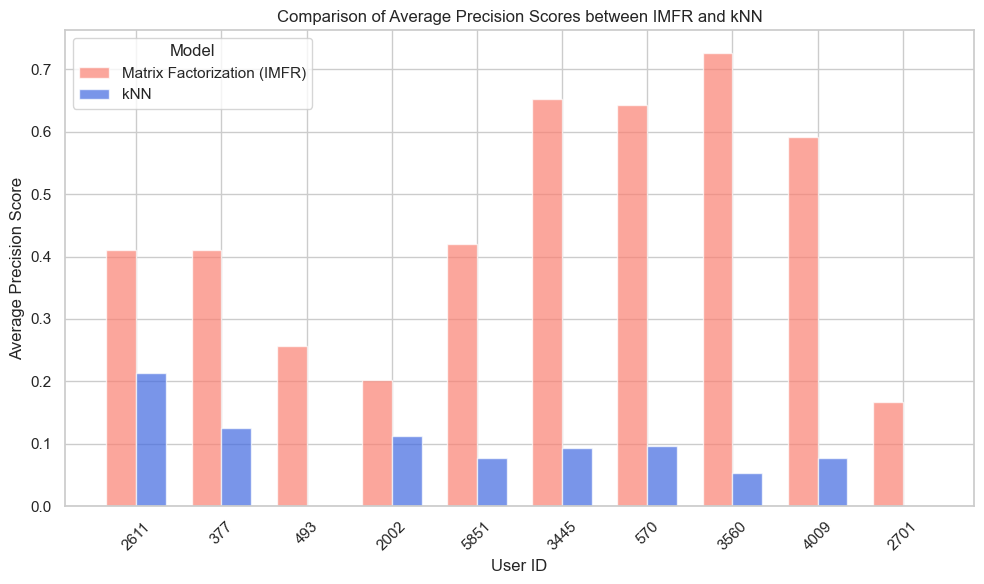

In [88]:
# Merge the two DataFrames on 'UserID' to facilitate comparison
comparison_df = pd.merge(ap_imfr_df[['UserID', 'AP Score']], 
                          ap_knn_df[['UserID', 'AP Score']], 
                          on='UserID', 
                          suffixes=('_IMFR', '_KNN'))

# Prepare data for plotting
user_ids = comparison_df['UserID']
ap_scores_imfr = comparison_df['AP Score_IMFR']
ap_scores_knn = comparison_df['AP Score_KNN']

# Set up the bar positions and width
x = range(len(user_ids))  # x positions for the bars
width = 0.35  # Width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define less saturated colors
color_imfr = '#A0C4FF'  # Light blue
color_knn = '#FFABAB'    # Light orange

# Plot the bars for each model with less saturated colors
bars1 = ax.bar(x, ap_scores_imfr, width, label='Matrix Factorization (IMFR)', color="salmon", alpha = 0.7)
bars2 = ax.bar([p + width for p in x], ap_scores_knn, width, label='kNN', color="royalblue", alpha = 0.7)

# Adding labels and title
ax.set_title('Comparison of Average Precision Scores between IMFR and kNN')
ax.set_xlabel('User ID')
ax.set_ylabel('Average Precision Score')
ax.set_xticks([p + width / 2 for p in x])  # Positioning ticks in the center of the grouped bars
ax.set_xticklabels(user_ids, rotation=45)
ax.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.show()


### NDCG

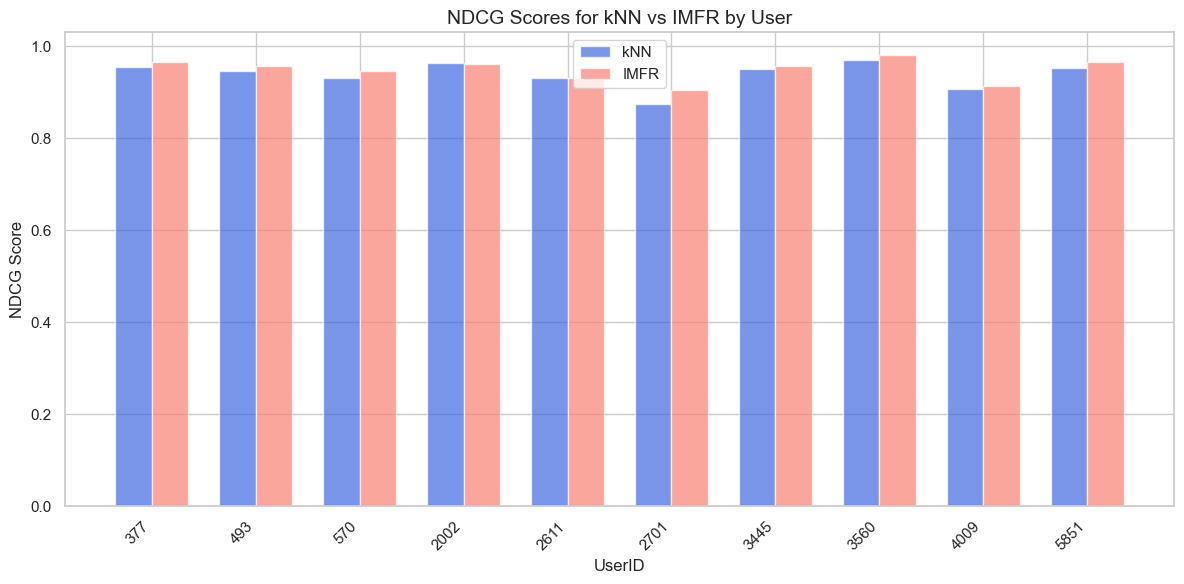

In [89]:
# Sort the DataFrame by UserID for consistent ordering
model_eval_df = model_eval_df.sort_values(by="UserID")

# Set figure size for readability
plt.figure(figsize=(12, 6))

# Set the bar width and positions
bar_width = 0.35
index = np.arange(len(model_eval_df))

# Plot NDCG scores for kNN
plt.bar(index, model_eval_df['NDCG Score_kNN'], bar_width, label='kNN', color='royalblue', alpha=0.7)

# Plot NDCG scores for IMFR, shifting the bars to the right for side-by-side comparison
plt.bar(index + bar_width, model_eval_df['NDCG Score_IMFR'], bar_width, label='IMFR', color='salmon', alpha=0.7)

# Labeling the x-axis with User IDs
plt.xlabel('UserID', fontsize=12)
plt.ylabel('NDCG Score', fontsize=12)
plt.title('NDCG Scores for kNN vs IMFR by User', fontsize=14)

# Add x-ticks and format to display the UserID
plt.xticks(index + bar_width / 2, model_eval_df['UserID'], rotation=45, ha='right')

# Display legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


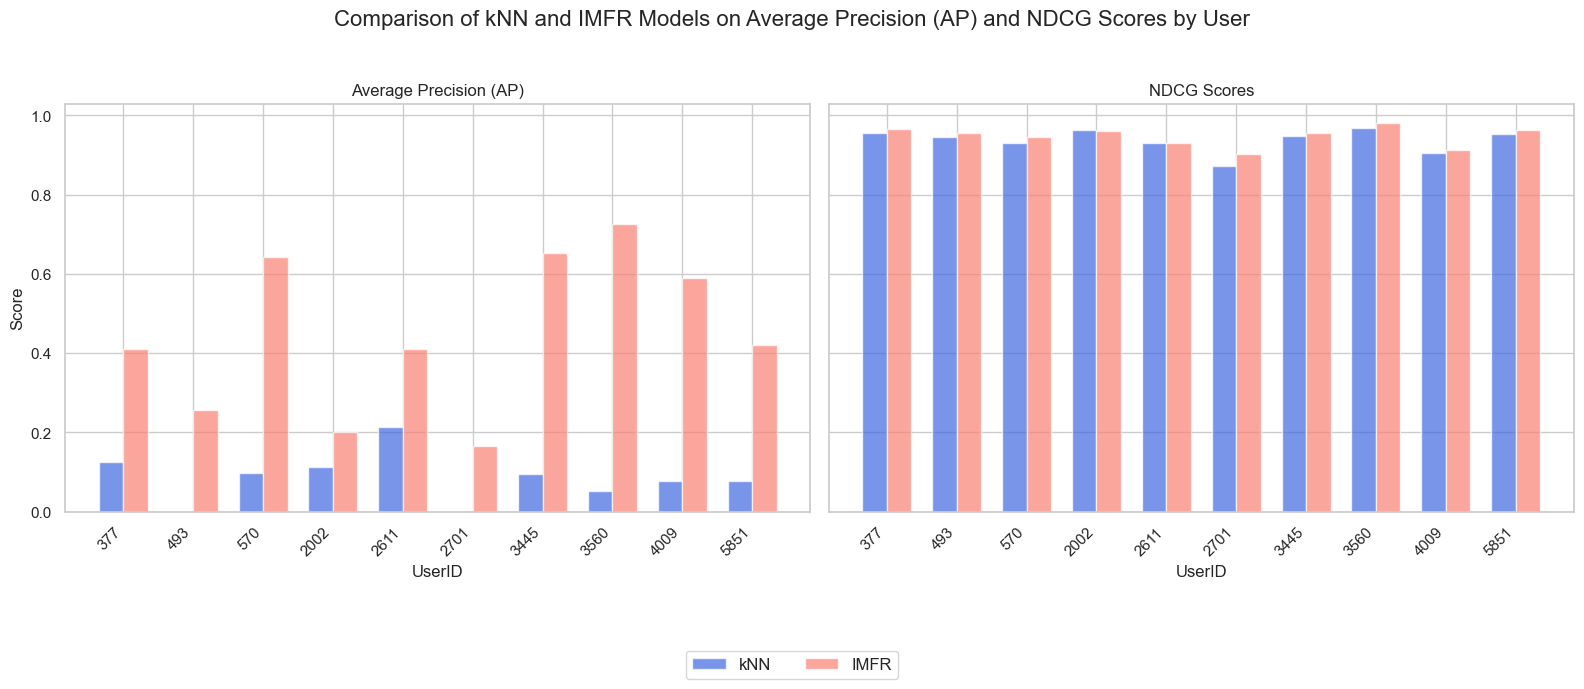

In [90]:
# Sort by UserID for consistent plotting
model_eval_df = model_eval_df.sort_values(by="UserID")

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Comparison of kNN and IMFR Models on Average Precision (AP) and NDCG Scores by User', fontsize=16)

# Index and bar width
index = np.arange(len(model_eval_df))
bar_width = 0.35

# Plot Average Precision (AP) scores
axes[0].bar(index, model_eval_df['AP Score_kNN'], bar_width, label='kNN', color='royalblue', alpha=0.7)
axes[0].bar(index + bar_width, model_eval_df['AP Score_IMFR'], bar_width, label='IMFR', color='salmon', alpha=0.7)
axes[0].set_title('Average Precision (AP)')
axes[0].set_xlabel('UserID')
axes[0].set_ylabel('Score')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(model_eval_df['UserID'], rotation=45, ha='right')

# Plot NDCG scores
axes[1].bar(index, model_eval_df['NDCG Score_kNN'], bar_width, label='kNN', color='royalblue', alpha=0.7)
axes[1].bar(index + bar_width, model_eval_df['NDCG Score_IMFR'], bar_width, label='IMFR', color='salmon', alpha=0.7)
axes[1].set_title('NDCG Scores')
axes[1].set_xlabel('UserID')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(model_eval_df['UserID'], rotation=45, ha='right')

# Adjust the legend position to below the subplots
fig.legend(['kNN', 'IMFR'], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.15))

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
